In [1]:
import random
from os import path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier

In [2]:
SEED = 491
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [4]:
data_path = "data/previous"
processed_seer = path.join(data_path, "processed_seer_with_age.csv")
processed_cohort = path.join(data_path, "processed_cohort_with_age.csv")
seer_dataset = pl.read_csv(processed_seer)
cohort_dataset = pl.read_csv(processed_cohort)

========== Train on SEER → Test on Cohort ==========


Model,AUC,Accuracy,Precision,Recall,F1
str,f64,f64,f64,f64,f64
"""Logistic Regression""",0.828613,0.826531,0.5,0.029412,0.055556
"""SVM""",0.809913,0.658163,0.314607,0.823529,0.455285
"""Random Forest""",0.806463,0.760204,0.396825,0.735294,0.515464
"""XGBoost""",0.804285,0.719388,0.363636,0.823529,0.504505
"""Neural Network""",0.787037,0.816327,0.0,0.0,0.0


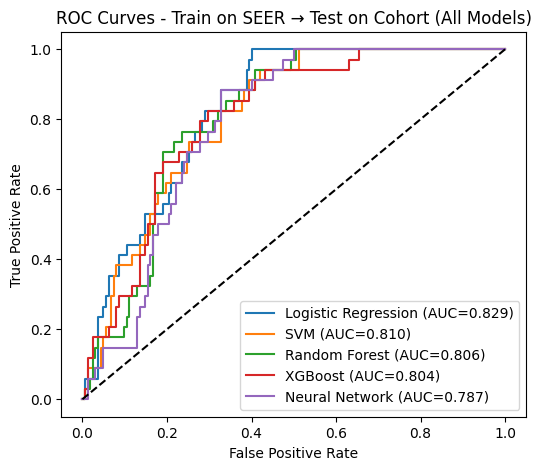

========== Train on Cohort → Test on SEER ==========


Model,AUC,Accuracy,Precision,Recall,F1
str,f64,f64,f64,f64,f64
"""Logistic Regression""",0.794737,0.902885,0.323835,0.321942,0.322886
"""SVM""",0.80279,0.733685,0.17328,0.716727,0.279086
"""Random Forest""",0.781823,0.871645,0.239007,0.359263,0.287049
"""XGBoost""",0.745197,0.831123,0.17874,0.375,0.24209
"""Neural Network""",0.775283,0.865403,0.220588,0.343975,0.268798


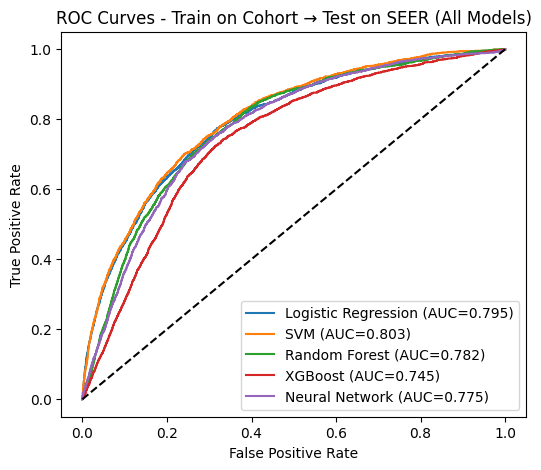

In [5]:
for TRAIN_DF, TEST_DF, NAME in [
    (seer_dataset, cohort_dataset, "Train on SEER → Test on Cohort"),
    (cohort_dataset, seer_dataset, "Train on Cohort → Test on SEER"),
]:
    print(f"========== {NAME} ==========")

    label_col = "target"
    X = TRAIN_DF.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
    y = TRAIN_DF.get_column(label_col).to_numpy().astype(np.int64).ravel()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    X_test = TEST_DF.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
    y_test = TEST_DF.get_column(label_col).to_numpy().astype(np.int64).ravel()

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train).astype(np.float32)
    X_val = scaler.transform(X_val).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)

    models = {
        "Logistic Regression": LogisticRegression(
            max_iter=5000
        ),
        "SVM": SVC(
            kernel="rbf",
            C=0.5,
            gamma=0.01,
            probability=True,
            class_weight="balanced",
            random_state=SEED
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=1200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features="sqrt",
            class_weight="balanced_subsample",
            random_state=SEED,
            n_jobs=-1,
        ),
        "XGBoost": XGBClassifier(
            eval_metric="logloss",
            random_state=SEED,
            n_estimators=500,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
        ),
    }

    results = []
    roc_curves = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.append([name, auc, acc, prec, rec, f1])
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_curves.append((name, fpr, tpr, auc))

    input_size = X_train.shape[1]
    hidden_size = 64
    nn_model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 2),
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

    train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    val_data = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
    test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32)
    test_loader = DataLoader(test_data, batch_size=32)

    best_val_auc = 0
    for epoch in range(50):
        nn_model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = nn_model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        nn_model.eval()
        with torch.no_grad():
            y_true, y_pred = [], []
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                outputs = nn_model(X_batch)
                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                y_true.extend(y_batch.numpy())
                y_pred.extend(probs)
            val_auc = roc_auc_score(y_true, y_pred)
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_model_state = nn_model.state_dict()

    nn_model.load_state_dict(best_model_state)
    nn_model.eval()
    with torch.no_grad():
        y_true, y_pred = [], []
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = nn_model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = np.argmax(outputs.cpu().numpy(), axis=1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(probs)

    auc = roc_auc_score(y_true, y_pred)
    y_bin = (np.array(y_pred) >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_bin)
    prec = precision_score(y_true, y_bin)
    rec = recall_score(y_true, y_bin)
    f1 = f1_score(y_true, y_bin)
    results.append(["Neural Network", auc, acc, prec, rec, f1])
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_curves.append(("Neural Network", fpr, tpr, auc))

    df_results = pl.DataFrame(results, schema=["Model", "AUC", "Accuracy", "Precision", "Recall", "F1"], orient="row")
    display(df_results)

    plt.figure(figsize=(6, 5))
    for name, fpr, tpr, auc in roc_curves:
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - {NAME} (All Models)")
    plt.legend()
    plt.show()

## Last Year's Results

### Train on SEER → Test on Local Cohort

| Model              | Test ROC AUC | Accuracy | Precision | Recall | F1 Score |
|--------------------|--------------|-----------|------------|---------|-----------|
| Neural Network     | 0.820        | 0.714     | 0.654      | 0.757   | 0.650     |
| Logistic Regression| 0.820        | 0.724     | 0.637      | 0.717   | 0.642     |
| Gradient Boosting  | 0.806        | 0.714     | 0.643      | 0.734   | 0.642     |
| SVM                | 0.830        | 0.724     | 0.665      | 0.775   | 0.662     |
| Random Forest      | 0.803        | 0.694     | 0.621      | 0.699   | 0.617     |
| XGBoost            | 0.807        | 0.689     | 0.625      | 0.707   | 0.617     |

### Train on Local Cohort → Test on SEER

| Model              | Test ROC AUC | Accuracy | Precision | Recall | F1 Score |
|--------------------|--------------|-----------|------------|---------|-----------|
| SVM                | 0.786        | 0.689     | 0.564      | 0.716   | 0.530     |
| Gradient Boosting  | 0.785        | 0.749     | 0.571      | 0.712   | 0.563     |
| Random Forest      | 0.783        | 0.748     | 0.572      | 0.715   | 0.563     |
| Logistic Regression| 0.781        | 0.713     | 0.565      | 0.709   | 0.541     |
| Neural Network     | 0.765        | 0.816     | 0.578      | 0.678   | 0.591     |
| XGBoost            | 0.767        | 0.749     | 0.571      | 0.713   | 0.563     |